In [ ]:
!pip install scipy==1.14.0
!pip install sktime --quiet
!pip install pyts --quiet
!pip install tsfresh --quiet
!pip install git+https://github.com/gon-uri/detach_rocket --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## 1) Download and Prepare Data: NOW MULTIVARIATE

### Download a dataset from the UEA archive

Instead of using the UCR, we will use the UEA, the archive for multivariate time series.
You can still get the description of the datasets in the following webpage: https://www.timeseriesclassification.com/dataset.php

In [ ]:
# We will use the UCR dataset

from detach_rocket.utils_datasets import fetch_uea_dataset
from pyts.datasets import uea_dataset_list

# Download Dataset
selected_dataset = ['SelfRegulationSCP1'] # SelfRegulationSCP1
print("Selected dataset:", selected_dataset)
current_dataset = fetch_uea_dataset(selected_dataset[0])

print(" ")
# You can later try other UCR datasets (First use WormsTwoClass dataset)
dataset_list = uea_dataset_list()
print("All UEA Datasets:", dataset_list)

Selected dataset: ['SelfRegulationSCP1']
 
All UEA Datasets: ['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'Ering', 'EthanolConcentration', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'LSST', 'Libras', 'MotorImagery', 'NATOPS', 'PEMS-SF', 'PenDigits', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']


In [ ]:
# Function to convert all labels to 0,1,2,3,4,etc..

def convert_labels_to_integers(labels):
    # Create a mapping of unique labels to integers
    unique_labels = sorted(set(labels))
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels using the mapping
    converted_labels = np.asarray([label_to_int[label] for label in labels])
    return converted_labels, label_to_int

### Information about the Dataset
**About the *SelfRegulationSCP1* dataset:** The dataset contains EEG recordings from a healthy subject performing a cursor control task through self-regulation of slow cortical potentials (SCPs), with 268 training trials and 293 test trials, each represented by six EEG channels recorded at 256 Hz for 3.5 seconds, and labeled based on cortical positivity or negativity.


### Create the corresponding Train and Test matrices

We unpack the dictionary downloaded form the UCR into the train and test matrices that we will use for training our models.

In [ ]:
import numpy as np

# Create data matrices and remove possible rows with nans or infs
print(f"Dataset Matrix Shape: ( # of instances , # of channels , time series length )")
print(f" ")

# Train Matrix
X_train = current_dataset['data_train'].copy()

# NOTICE TAHAT THIS PART IS DIFFERENT FOR THE MULTIVARIATE CASE
# This part is to make shure there is no nans of inf in the data
non_nan_mask_train = ~np.isnan(~np.isnan(X_train).any(axis=1)).any(axis=1) # We have to check in both dimensions (channels and timesteps)
non_inf_mask_train = ~np.isnan(~np.isnan(X_train).any(axis=1)).any(axis=1) # We have to check in both dimensions (channels and timesteps)
mask_train = np.logical_and(non_nan_mask_train,non_inf_mask_train)
X_train = X_train[mask_train]

# Shuffle dataset to avoid any possible bias (keep indexes to shuffle the labels)
np.random.seed(42)
indexes = np.arange(X_train.shape[0])
np.random.shuffle(indexes)
X_train = X_train[indexes]

print(f"Train Matrix Shape: {X_train.shape}")

# We create the labels
y_train = current_dataset['target_train'].copy()

# Conver the labels to integers starting from zero
y_train, label_to_int = convert_labels_to_integers(y_train)

# Remove nans also form labels
y_train = y_train[mask_train]

# Shuffle the labels in the same way as the data
y_train = y_train[indexes]

print(f" ")

# Test Matrix
X_test = current_dataset['data_test'].copy()

# NOTICE TAHAT THIS PART IS DIFFERENT FOR THE MULTIVARIATE CASE
# This part is to make shure there is no nans of inf in the data
non_nan_mask_test = ~np.isnan(~np.isnan(X_test).any(axis=1)).any(axis=1) # We have to check in both dimensions (channels and timesteps)
non_inf_mask_test = ~np.isnan(~np.isnan(X_test).any(axis=1)).any(axis=1) # We have to check in both dimensions (channels and timesteps)
mask_test = np.logical_and(non_nan_mask_test,non_inf_mask_test)
X_test = X_test[mask_test]

print(f"Test Matrix Shape: {X_test.shape}")

y_test = current_dataset['target_test'].copy()

# Remove nans also form labels
y_test = y_test[mask_test]

# Conver the labels to integers starting from zero
y_test = np.asarray([label_to_int[label] for label in y_test])

# Print the different unique classes
print(f" ")
print(f"Unique Classes: {np.unique(y_train)}")
number_of_classes = len(np.unique(y_train))

# Print the proportion of each class
print(f" ")
for i in np.unique(y_train):
    print(f"Class {i} has {np.sum(y_train==i)/len(y_train)*100:.2f}% of the data")

Dataset Matrix Shape: ( # of instances , # of channels , time series length )
 
Train Matrix Shape: (268, 6, 896)
 
Test Matrix Shape: (293, 6, 896)
 
Unique Classes: [0 1]
 
Class 0 has 50.37% of the data
Class 1 has 49.63% of the data


### Plotting the time series data

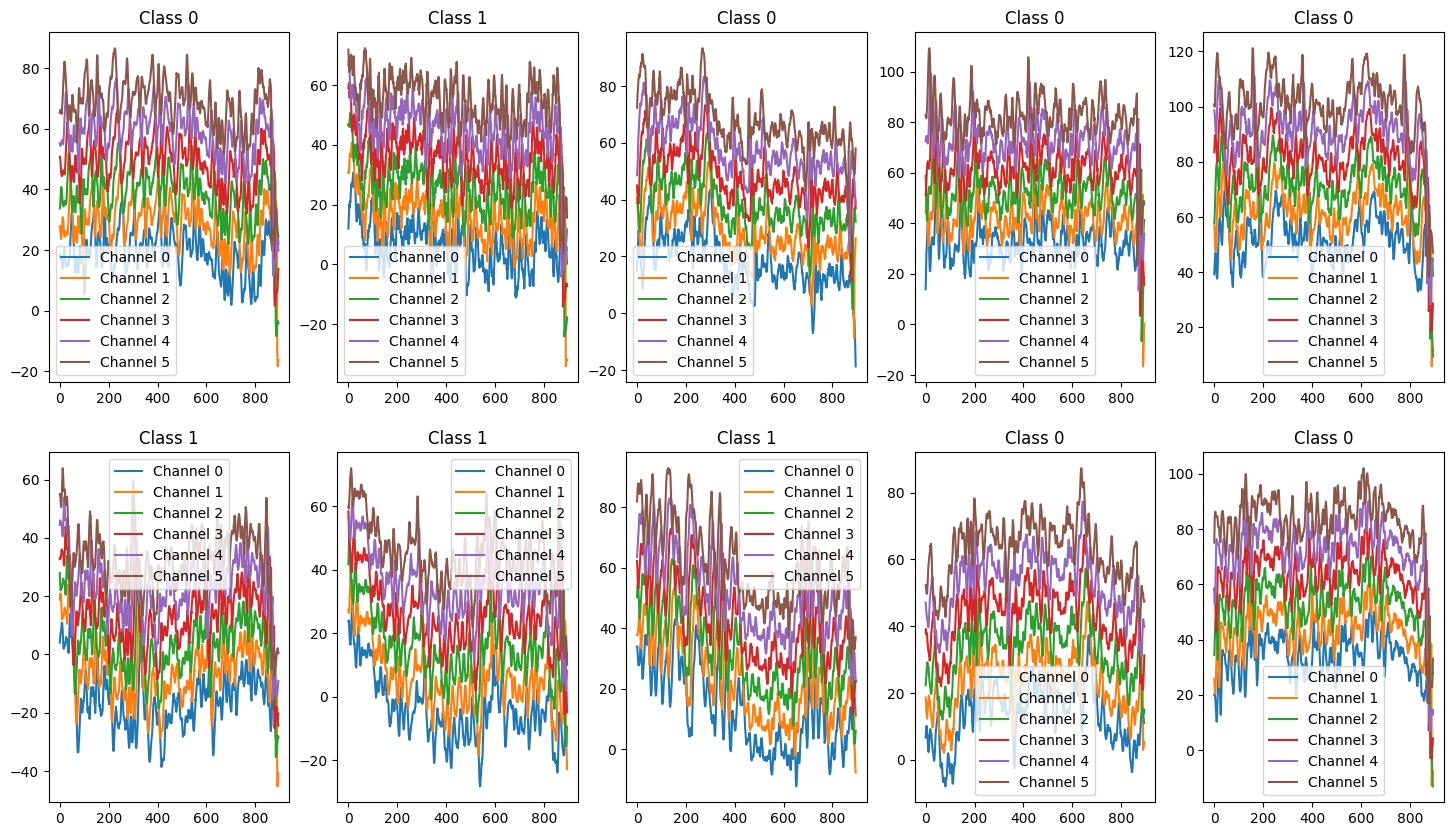

In [ ]:
# Plot the 10 instances in a subplot
import matplotlib.pyplot as plt

# Plot the first 10 instances of the multivariate time series data of shape (num_instances, num_channels, num_timesteps)
plt.figure(figsize=(18,10))
for i in range(10):
    plt.subplot(2,5,i+1)

    for j in range(X_train.shape[1]):

        # We add an offset to the data to make it more readable
        offset = 10
        plt.plot(X_train[i,j,:]+10*j, label=f"Channel {j}")
    plt.legend()

    plt.title(f"Class {y_train[i]}")
plt.show()


Notice that the values in each EEG channel are not exactly the same, but they are highly correlated!

## 2) ROCKET classifier

A Rocket classifier consists in two stages. The first one is to convert the data using the Rocket transformation. The second one is to classify that data using a regularized ridge classifier.

In [ ]:
from sktime.transformations.panel.rocket import MultiRocketMultivariate, MiniRocketMultivariate

# First Stage: Transformation

# Create the transformation
np.random.seed(1)
rocket_trf = MultiRocketMultivariate()

# Fit the transformation
rocket_trf.fit(X_train)

# Transform the data
rocket_X_train = rocket_trf.transform(X_train)
rocket_X_test = rocket_trf.transform(X_test)

# Print the shape of the new dataset
print(f"Rocket Features Matrix Shape: ( # of instances , # of features )")
print(f" ")
print(f"Train: {rocket_X_train.shape}")
print(f" ")
print(f"Test: {rocket_X_test.shape}")

Rocket Features Matrix Shape: ( # of instances , # of features )
 
Train: (268, 49728)
 
Test: (293, 49728)


Lets now use this very large amount of features to classify. We will use a Ridge classifier, which is a lenar classifier with l2 regularization. With the Ridge Classifier we can implemente a leave-one-out cross validation (LOOCV) proccess almost "for free" in terms of proccesing.

Accuracy Train = 1.00
Accuracy Test = 0.90
 
Confusion Matrix on Test Set: 


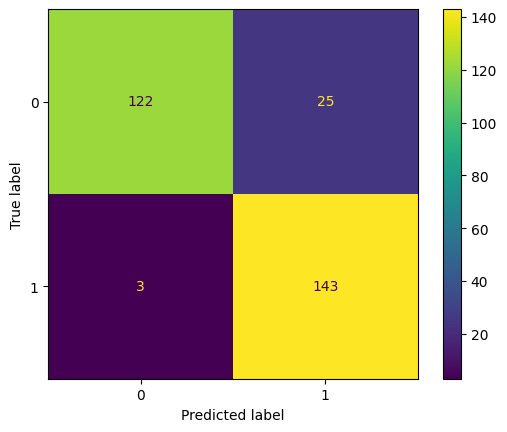

In [ ]:
# Second Stage : Calssification

# Train a ridge classifier on the data
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# We create a Ridge Classifier to perform the classification task
rocket_classifier = RidgeClassifierCV(alphas=np.logspace(-10,10,20), class_weight='balanced')

rocket_classifier.fit(rocket_X_train, y_train)

# Predict on the train set
y_pred_train = rocket_classifier.predict(rocket_X_train)

# Calculate the accuracy
accuracy_train = accuracy_score(y_train,y_pred_train)

# Predict on the test set
y_pred_test = rocket_classifier.predict(rocket_X_test)

# Calculate the accuracy
accuracy_test = accuracy_score(y_test,y_pred_test)

# Print Accuracy
print(f"Accuracy Train = {accuracy_train:.2f}")
print(f"Accuracy Test = {accuracy_test:.2f}")

print(f" ")
print(f"Confusion Matrix on Test Set: ")
# Plot confusion matrix
conf_matrix_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test,display_labels=np.unique(y_test))
disp.plot()
plt.show()

## 3) Exercises:

1) The channels in the EEG data set are highly correlated. What does this mean? Is it really necessary to have all the channels to classify? Try to answer this question by subsampling the channels (selecting only a subset of channels) and see if this affects your prediction accuracy (or not).

2) Try using Minirocket instead of Multirocket. Compare the number of features generated by each model. Is there a difference in accuracy for the classification task?

3) Try different multivariate datasets from the UEA archive.

4) Now implement a calsifier on the data using Catch22. Compare its accuracy with that of the ROCKET classifier. Tip: Reuse the code from the previous notebooks.

5) You can also try to run the CNN models below.


## [EXTRA] 4) CNN Model
We will train a vanilla CNN architecture to solve the classification task.

In [ ]:
# The definition of these callbacks is just to store the accuracy values during training process.
# There is no need to modify or understand this part of the code.

import tensorflow as tf
from sklearn.metrics import accuracy_score

acc_list_train = []
acc_list_test = []

class AccuracyCallbackTrain(tf.keras.callbacks.Callback):
    def __init__(self, X, y, threshold=0.5):
        super().__init__()
        self.X = np.swapaxes(X, 1, 2) # Correct the shape if necessary
        self.y = y
        self.threshold = threshold  # Threshold for binary classification (default 0.5)

    def on_epoch_end(self, epoch, logs=None):

        # Get predictions on the entire training set
        predictions = self.model.predict(self.X)
        y_pred = predictions.argmax(axis=1)
        accuracy = accuracy_score(self.y, y_pred)

        # Store accuracy value
        acc_list_train.append(accuracy)
        #print(f"Epoch {epoch + 1}: Accuracy = {accuracy:.4f}")

class AccuracyCallbackTest(tf.keras.callbacks.Callback):
    def __init__(self, X, y, threshold=0.5):
        super().__init__()
        self.X = np.swapaxes(X, 1, 2) # Correct the shape if necessary
        self.y = y
        self.threshold = threshold  # Threshold for binary classification (default 0.5)

    def on_epoch_end(self, epoch, logs=None):

        # Get predictions on the entire training set
        predictions = self.model.predict(self.X)
        y_pred = predictions.argmax(axis=1)
        accuracy = accuracy_score(self.y, y_pred)

        # Store accuracy value
        acc_list_test.append(accuracy)
        #print(f"Epoch {epoch + 1}: Accuracy = {accuracy:.4f}")

Let's train the simple CNN model on the raw time series data.

By default, this model will posses the following hyperparameters:

*   kernel_size = 7
*   avg_pool_size = 3
*   n_conv_layers = 2
*   filter_sizes = [6, 12] (this is the number of kernelsper layer, need to be equal to the number of layers)

You can read more in depth about it in the corresponding documentation:
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.deep_learning.CNNClassifier.html

In [ ]:
from sktime.classification.deep_learning import CNNClassifier

# Initialize the callbacks (this is to keep track of the learning process while training)
train_accuracy_callback = AccuracyCallbackTrain(X_train, y_train)
test_accuracy_callback = AccuracyCallbackTest(X_test, y_test)
acc_list_train = []
acc_list_test = []

# Create the classifier
cnn_classifier = CNNClassifier(

    # PARAMETERS
    n_epochs=50, # Number of epochs
    #kernel_size = 15,
    #avg_pool_size = 5,
    #n_conv_layers = 3,
    #filter_sizes = [6, 6, 6],

    verbose=True, # Print information about the training
    callbacks=[train_accuracy_callback,test_accuracy_callback] # Call the custom callbacks we have created
    )

# Train the model
cnn_classifier.fit(X_train, y_train)

In [ ]:
# Plot both the loss and the accuracies (train and test) in the same graph using two different y-axis.
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(cnn_classifier.history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc_list_train, color=color, linestyle='dashed', label='Train Accuracy')
ax2.plot(acc_list_test, color=color, linestyle='solid', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc="upper right")
fig.tight_layout()
plt.show()

In [ ]:
# Compute and print the accuracy on the train and test set using the final model

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_test_pred = cnn_classifier.predict(X_test)
y_train_pred = cnn_classifier.predict(X_train)

# Predict the train set
y_train_pred = cnn_classifier.predict(X_train)

# Calculate the accuracy
accuracy_train = accuracy_score(y_train,y_train_pred)

# Calculate the accuracy
accuracy_test = accuracy_score(y_test,y_test_pred)

print(f"Accuracy Train = {accuracy_train:.2f}")
print(f"Accuracy Test = {accuracy_test:.2f}")

## [EXTRA] 5) InceptionTime Classifier

Let us now train an IncpetionTime classifier. The original IncpetionTime model consists of an ensemble of 5 individual IncpetionTime networks, here we are just training one. An ensemble is used to counteract the fact that the individual IncpetionTime networks tend to have a lot of variability (some realisations of the model perform really well and others dont).

The Keras implementation used in SKTime is not ideal, it will take a lot to train, and it doesnt handle very well the BatchNormalization curves when using for evaluation.

In [ ]:
from sktime.classification.deep_learning import InceptionTimeClassifier

batch_size = 64
inctime = InceptionTimeClassifier(n_epochs=10,batch_size=batch_size, verbose=True)
inctime.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a dummy batch to force update BN statistics
dummy_input = np.copy(X_train[:batch_size])  # Assuming batch size
_ = inctime.predict(dummy_input)  # This updates the internal BN statistics

y_train_pred = inctime.predict(X_train)
y_test_pred = inctime.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")